In [ ]:
! pip install pmdarima

In [ ]:
! pip install fbprophet

In [ ]:
! pip install neuralprophet

IMPORT MODULES

In [10]:
# Imports
import pandas as pd
import numpy as np
import io
from datetime import date, datetime
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid
import random

import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from neuralprophet import NeuralProphet
from fbprophet import Prophet

import warnings
warnings.filterwarnings('ignore')

IMPORT DATASET

In [11]:
# Read data file and convert to pandas df with columns renamed
df = pd.read_csv('AirQuality.csv', delimiter = ';', decimal = ',', usecols = ['Date', 'Time', 'CO(GT)', 'T'])
df.rename(columns = {'Date' : 'DATE', 'Time' : 'TIME', 'CO(GT)' : 'CO', 'T' : 'TEMP'}, inplace = True)

EXPLORATORY DATA ANALYSIS

In [12]:
df.head()

,DATE,TIME,CO,TEMP
0,10/03/2004,18.00.00,2.6,13.6
1,10/03/2004,19.00.00,2.0,13.3
2,10/03/2004,20.00.00,2.2,11.9
3,10/03/2004,21.00.00,2.2,11.0
4,10/03/2004,22.00.00,1.6,11.2


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    9357 non-null   object 
 1   TIME    9357 non-null   object 
 2   CO      9357 non-null   float64
 3   TEMP    9357 non-null   float64
dtypes: float64(2), object(2)
memory usage: 296.1+ KB


114 rows containing nulls are present which need to be dropped.

In [14]:
df.describe()

,CO,TEMP
count,9357.000000,9357.000000
mean,-34.207524,9.778305
std,77.657170,43.203623
min,-200.000000,-200.000000
25%,0.600000,10.900000
50%,1.500000,17.200000
75%,2.600000,24.100000
max,11.900000,44.600000


In [15]:
# Drop nulls
df = df.dropna()

# Convert date column from object to datetime object (format - yyyy-mm-dd) for plotting daywise CO and Temp
df['TIME'] = (df['TIME'].replace('\.',':', regex = True))
df.loc[:,'DATE_TIME'] = pd.to_datetime(df.DATE.astype(str) + ' ' + df.TIME.astype(str))

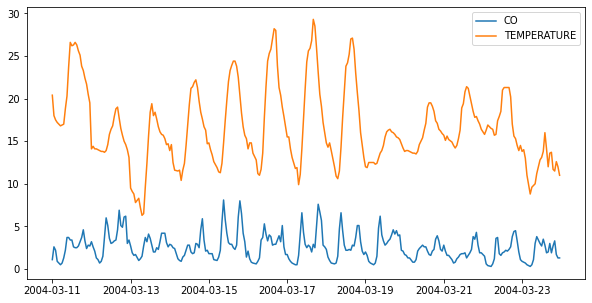

In [16]:
# Filter for training set and remove rows containing CO or Temp containing -200.
df_filter = df[(df.DATE_TIME >= pd.to_datetime('2004-03-11')) & (df.DATE_TIME < pd.to_datetime('2004-03-24'))]
df_ = df_filter[~((df_filter.CO == -200) | (df_filter.TEMP == -200))]
df_ = df_.sort_values(by = 'DATE_TIME')

plt.subplots(figsize = (10, 5))
plt.plot(df_.DATE_TIME, df_.CO)
plt.plot(df_.DATE_TIME, df_.TEMP)
plt.legend(['CO', 'TEMPERATURE'])
plt.show()

There is high variance in the training data, especially for Temperature.

FEATURE ENGINEERING

In [17]:
'''
Data Preprocessing
'''

# Sort by DATE_TIME 
df = df.sort_values(by = 'DATE_TIME').reset_index(drop = True)

# Handling missing values marked with -200
# Replace -200 with NaN
df.loc[df.CO == -200, 'CO'] =  np.nan
df.loc[df.TEMP == -200, 'TEMP'] =  np.nan

# Linear interpolation
df['LIN_INTERPOLATE_T'] = df.TEMP.interpolate(method = 'linear', axis = 0)
df['LIN_INTERPOLATE_CO'] = df.CO.interpolate(method = 'linear', axis = 0)

# Backfill
df['BFILL_T'] = df.TEMP.bfill(axis = 'rows')
df['BFILL_CO'] = df.CO.bfill(axis = 'rows')

# ForwardFill
df['FFILL_T'] = df.TEMP.ffill(axis = 'rows')
df['FFILL_CO'] = df.CO.ffill(axis = 'rows')

# Average of value and hour prior and after, rolling avergae over 1 day and rolling avergae over 7 days for CO
indexes = df[df['CO'].isnull()].index.tolist()
df['AVG_CO'] = df['CO']
df['SMA_CO_1_DAY'] = df['CO']
df['SMA_CO_7_DAY'] = df['CO']
for i in indexes:
  if (pd.isna(df.loc[i - 1, 'AVG_CO'])) & (pd.isna(df.loc[i + 1, 'AVG_CO'])):
    df.at[i, 'AVG_CO'] = (df.loc[i - 1, 'AVG_CO'] + df.loc[i + 1, 'AVG_CO']) / 2
  else:
      df.at[i, 'AVG_CO'] = df.loc[i - 1, 'AVG_CO']
  
  df.at[i, 'SMA_CO_1_DAY'] = np.mean(df.loc[i - 24 : i, 'SMA_CO_1_DAY'])
  df.at[i, 'SMA_CO_7_DAY'] = np.mean(df.loc[i - 162 : i, 'SMA_CO_7_DAY'])

# Average of value and hour prior and after, rolling avergae over 1 day and rolling avergae over 7 days for TEMP
indexes = df[df['TEMP'].isnull()].index.tolist()
df['AVG_T'] = df['TEMP']
df['SMA_T_1_DAY'] = df['TEMP']
df['SMA_T_7_DAY'] = df['TEMP']
for i in indexes:
  if (pd.isna(df.loc[i - 1, 'AVG_T'])) & (pd.isna(df.loc[i + 1, 'AVG_T'])): 
    df.at[i, 'AVG_T'] = (df.loc[i-1, 'AVG_T'] + df.loc[i + 1, 'AVG_T']) / 2
  else:
    df.at[i, 'AVG_T'] = df.loc[i - 1, 'AVG_T']

  df.at[i, 'SMA_T_1_DAY'] = np.mean(df.loc[i - 24 : i, 'SMA_T_1_DAY'])
  df.at[i, 'SMA_T_7_DAY'] = np.mean(df.loc[i - 162 : i, 'SMA_T_7_DAY'])

# Extract Month, Day, Hour from DATE_TIME column
df['MONTH'] = df['DATE_TIME'].dt.month
df['DAY'] = df['DATE_TIME'].dt.day
df['HOUR'] = df['DATE_TIME'].dt.hour 

# Cyclical encoding for hour, day, month 
cyclical_cols = {'MONTH' : 12, 'DAY' : 31, 'HOUR' : 23}
for c, max_val in cyclical_cols.items():
  df[c + '_sin'] = np.sin(2 * np.pi * df[c] / max_val)
  df[c + '_cos'] = np.cos(2 * np.pi * df[c] / max_val)

# Drop unnecessary columns
df = df.drop(['DATE', 'TIME', 'MONTH', 'DAY', 'HOUR'], axis = 1)

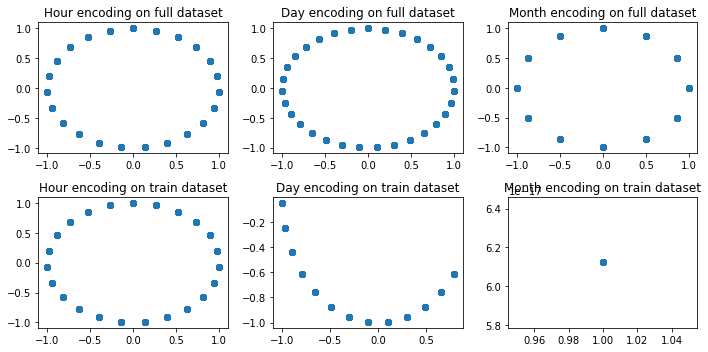

In [18]:
# Filter for training set
df_filter = df[(df.DATE_TIME >= pd.to_datetime('2004-03-11')) & (df.DATE_TIME < pd.to_datetime('2004-03-24'))]

# Encodings for cyclical column (DATE)
fig, axes = plt.subplots(2, 3, figsize = (10, 5), tight_layout = True)
axes[0,0].set_title('Hour encoding on full dataset')
axes[0,0].scatter(df.HOUR_sin, df.HOUR_cos)

axes[0,1].set_title('Day encoding on full dataset')
axes[0,1].scatter(df.DAY_sin, df.DAY_cos)

axes[0,2].set_title('Month encoding on full dataset')
axes[0,2].scatter(df.MONTH_sin, df.MONTH_cos)

axes[1,0].set_title('Hour encoding on train dataset')
axes[1,0].scatter(df_filter.HOUR_sin, df_filter.HOUR_cos)

axes[1,1].set_title('Day encoding on train dataset')
axes[1,1].scatter(df_filter.DAY_sin, df_filter.DAY_cos)

axes[1,2].set_title('Month encoding on train dataset')
axes[1,2].scatter(df_filter.MONTH_sin, df_filter.MONTH_cos)

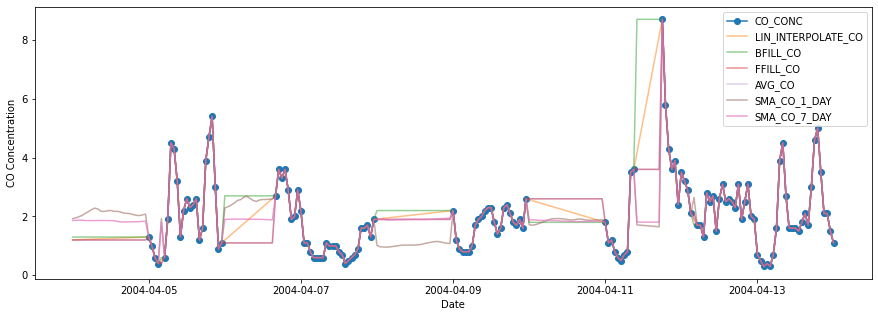

In [19]:
# Filter rows to understand the results of feature engineering missing values. This date range contains 98 missing values for CO and have been imputed using the above methods.
df_filter = df[(df.DATE_TIME >= pd.to_datetime('2004-04-01')) & (df.DATE_TIME <= pd.to_datetime('2004-04-14'))]

plt.subplots(figsize = (15, 5))
plt.plot(df_filter.DATE_TIME, df_filter.CO, marker = 'o')
plt.plot(df_filter.DATE_TIME, df_filter.LIN_INTERPOLATE_CO, alpha = 0.5)
plt.plot(df_filter.DATE_TIME, df_filter.BFILL_CO, alpha = 0.5)
plt.plot(df_filter.DATE_TIME, df_filter.FFILL_CO, alpha = 0.5)
plt.plot(df_filter.DATE_TIME, df_filter.AVG_CO, alpha = 0.3)
plt.plot(df_filter.DATE_TIME, df_filter.SMA_CO_1_DAY, alpha = 0.5)
plt.plot(df_filter.DATE_TIME, df_filter.SMA_CO_7_DAY, alpha = 0.7)
plt.xlabel('Date')
plt.ylabel('CO Concentration')
plt.legend(['CO_CONC', 'LIN_INTERPOLATE_CO', 'BFILL_CO', 'FFILL_CO', 'AVG_CO', 'SMA_CO_1_DAY', 'SMA_CO_7_DAY'])
plt.show()

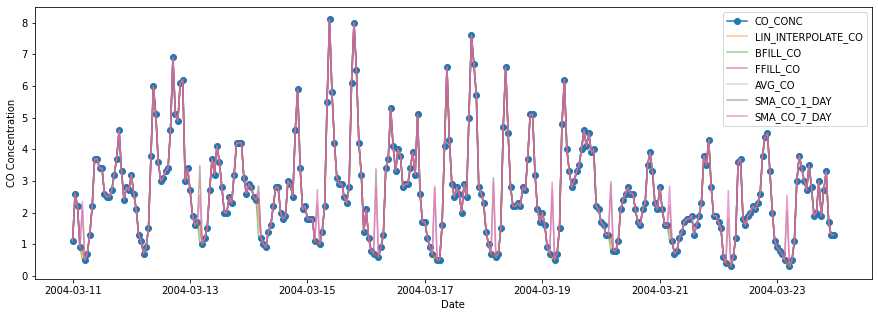

In [20]:
# Filter for training set which contains only 5 missing values for CO and none for temperature.
df_filter = df[(df.DATE_TIME >= pd.to_datetime('2004-03-11')) & (df.DATE_TIME < pd.to_datetime('2004-03-24'))]

plt.subplots(figsize = (15, 5))
plt.plot(df_filter.DATE_TIME, df_filter.CO, marker = 'o')
plt.plot(df_filter.DATE_TIME, df_filter.LIN_INTERPOLATE_CO, alpha = 0.5)
plt.plot(df_filter.DATE_TIME, df_filter.BFILL_CO, alpha = 0.5)
plt.plot(df_filter.DATE_TIME, df_filter.FFILL_CO, alpha = 0.5)
plt.plot(df_filter.DATE_TIME, df_filter.AVG_CO, alpha = 0.3)
plt.plot(df_filter.DATE_TIME, df_filter.SMA_CO_1_DAY, alpha = 0.5)
plt.plot(df_filter.DATE_TIME, df_filter.SMA_CO_7_DAY, alpha = 0.7)
plt.xlabel('Date')
plt.ylabel('CO Concentration')
plt.legend(['CO_CONC', 'LIN_INTERPOLATE_CO', 'BFILL_CO', 'FFILL_CO', 'AVG_CO', 'SMA_CO_1_DAY', 'SMA_CO_7_DAY'])
plt.show()

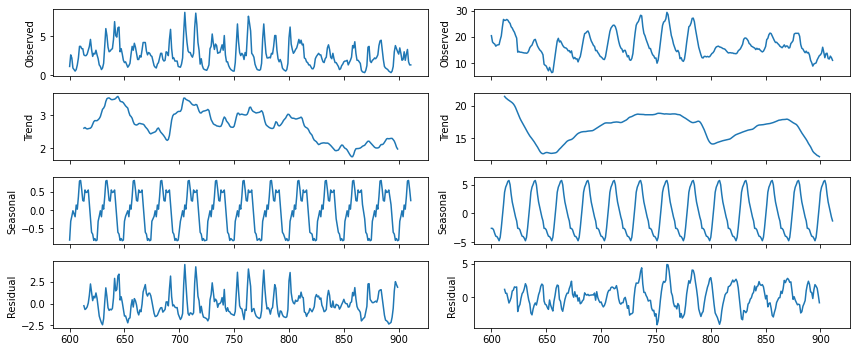

In [21]:
# Seasonal decompose to check for seasonality and trend in training set.
df_filter = df[['DATE_TIME', 'CO', 'TEMP']]
df_filter = df_filter[(df_filter.DATE_TIME >= pd.to_datetime('2004-03-11')) & (df_filter.DATE_TIME < pd.to_datetime('2004-03-24'))]

result_co = seasonal_decompose(df_filter.CO.dropna(), model = 'additive', period = 24)
result_temp = seasonal_decompose(df_filter.TEMP.dropna(), model = 'additive', period = 24)

def plotseasonal(res, axes ):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

fig, axes = plt.subplots(ncols = 2, nrows = 4, sharex = True, figsize = (12, 5))

plotseasonal(result_co, axes[:,0])
plotseasonal(result_temp, axes[:,1])

plt.tight_layout()
plt.show()

There appears to be no continuous trend in both CO and Temp in the training set (2004-03-11 to 2004-03-23). However, the data has a daily seasonality.

BASELINE MODELS 

In [22]:
# Set train and test dates
train_start_date = date(2004, 3, 11)

test_dates_datetime = pd.date_range(start = '2004-03-18', end = '2004-03-24')
test_dates_string = [d.strftime('%Y-%m-%d') for d in test_dates_datetime]
test_dates = [datetime.strptime(d, '%Y-%m-%d').date() for d in test_dates_string]

In [23]:
cols_co = ['CO', 'LIN_INTERPOLATE_CO', 'BFILL_CO', 'FFILL_CO', 'SMA_CO_1_DAY', 'SMA_CO_7_DAY', 'AVG_CO']
cols_t = ['TEMP']

In [24]:
def prediction_plots(df, col, pred_col):
  plt.subplots(figsize = (10, 3))
  plt.plot(df.DATE_TIME, df[col])
  plt.plot(df.DATE_TIME, df[pred_col])
  plt.legend([col, pred_col])
  plt.show()

*Exponential Smoothing*

In [25]:
def exponential_smoothing(col):
  # Create empty dataframe to store predictions
  predictions = pd.DataFrame()
  # Create empty list to store mape values
  mape_list = []

  # Iterate for all test dates
  for d in test_dates:
    mape_value = []

    # Get train set
    train = df[(df['DATE_TIME'].dt.date >= train_start_date) & (df['DATE_TIME'].dt.date < d)].set_index('DATE_TIME').dropna(subset = [col])

    # Get test set	
    test = df[(df['DATE_TIME'].dt.date == d)].set_index('DATE_TIME').dropna(subset = [col])

    # Train model and make predictions
    model = ExponentialSmoothing(train[col], seasonal = 'mul', seasonal_periods = 24).fit()
    pred = np.array(model.forecast(len(test)))
    test['PREDICTED_' + col + '_SES'] = pred

    # Calculate MAPE
    mape_value.append(mean_absolute_percentage_error(test[col], test['PREDICTED_' + col + '_SES']))

    # Append results
    test_filtered = test[[col, 'PREDICTED_' + col + '_SES']]
    predictions = predictions.append(test_filtered)
    mape_list.append(mape_value)
  
  predictions = predictions.reset_index()
  
  # Convert mape_list to df and calculate avergae mape for test set
  mape_df = pd.DataFrame(mape_list, columns = [col], index = test_dates)
  mape_df.loc['Average'] = mape_df.mean()
  
  # Return mape dataframe and predictions dataframe
  return mape_df, predictions

In [26]:
def exponential_smoothing_predictions_all():
	# Get CO and TEMP predicitons using auto_arima
	mape_co, predictions_co = exponential_smoothing('CO')
	mape_temp, predictions_temp = exponential_smoothing('TEMP')

	# Write to excel
	with pd.ExcelWriter('Predictions_ExponentialSmoothing.xlsx') as writer:  
		predictions_co.to_excel(writer, sheet_name = 'CO_ExponentialSmoothing')
		predictions_temp.to_excel(writer, sheet_name = 'Temp_ExponentialSmoothing')

	return mape_co, mape_temp, predictions_co, predictions_temp

In [27]:
mape_co_exponentialsmoothing, mape_temp_exponentialsmoothing, predictions_co_exponentialsmoothing, predictions_temp_exponentialsmoothing = exponential_smoothing_predictions_all()

In [28]:
# MAPE values for CO and TEMP using Exponential Smoothing
mape_exponentialsmoothing = pd.concat([mape_co_exponentialsmoothing, mape_temp_exponentialsmoothing], axis = 1)
mape_exponentialsmoothing

,CO,TEMP
2004-03-18,0.479754,0.082678
2004-03-19,0.529232,0.139071
2004-03-20,0.273057,0.117455
2004-03-21,0.230828,0.098078
2004-03-22,0.734041,0.153658
2004-03-23,0.696812,0.310662
2004-03-24,0.566951,0.175360
Average,0.501525,0.153852


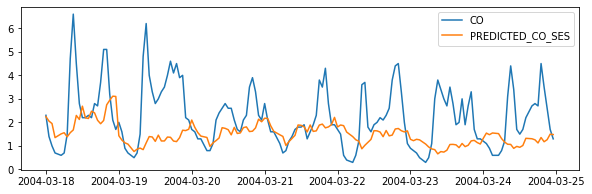

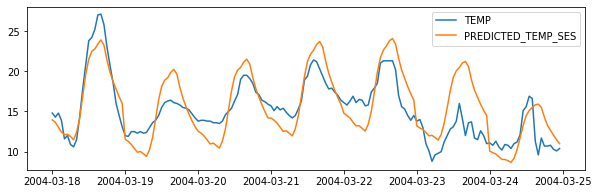

In [29]:
# Plot predictions using Exponential Smoothing
prediction_plots(predictions_co_exponentialsmoothing, 'CO', 'PREDICTED_CO_SES')
prediction_plots(predictions_temp_exponentialsmoothing, 'TEMP', 'PREDICTED_TEMP_SES')

*Auto Arima*

In [30]:
def arima(col):
  # Create empty dataframe to store predictions
  predictions = pd.DataFrame()
  # Create empty list to store mape values
  mape_list = []

  # Iterate for all test dates
  for d in test_dates:
    mape_value = []

    # Get train set
    train = df[(df['DATE_TIME'].dt.date >= train_start_date) & (df['DATE_TIME'].dt.date < d)].set_index('DATE_TIME').dropna(subset = [col])

    # Get test set	
    test = df[(df['DATE_TIME'].dt.date == d)].set_index('DATE_TIME').dropna(subset = [col])

    # Exogneous factors (month encoding not considered as the train and test set have same month for all values)
    exog_train = train[['DAY_sin', 'DAY_cos', 'HOUR_sin', 'HOUR_cos']]
    exog_test = test[['DAY_sin', 'DAY_cos', 'HOUR_sin', 'HOUR_cos']]

    # auto_arima model training and predictions
    model = pm.auto_arima(y = train[col], X = exog_train, start_p = 1, start_q = 1, test_g = 'adf', seasonal = False).fit(train[col])
    pred = np.array(model.predict(n_periods = len(test), X = exog_test))
    test['PREDICTED_' + col + '_ARIMA'] = pred

    # Calculate MAPE
    mape_value.append(mean_absolute_percentage_error(test[col], test['PREDICTED_' + col + '_ARIMA']))

    # Append results
    test_filtered = test[[col, 'PREDICTED_' + col + '_ARIMA']]
    predictions = predictions.append(test_filtered)
    mape_list.append(mape_value)

  predictions = predictions.reset_index()

	# Convert mape_list to df and calculate avergae mape for test set
  mape_df = pd.DataFrame(mape_list, columns = [col], index = test_dates)
  mape_df.loc['Average'] = mape_df.mean()

	# Return mape dataframe and predictions dataframe
  return mape_df, predictions

In [31]:
def arima_predictions_all():
	# Get CO and TEMP predicitons using auto_arima
	mape_co, predictions_co = arima('CO')
	mape_temp, predictions_temp = arima('TEMP')

	# Write to excel
	with pd.ExcelWriter('Predictions_AutoArima.xlsx') as writer:  
		predictions_co.to_excel(writer, sheet_name = 'CO_AutoArima')
		predictions_temp.to_excel(writer, sheet_name = 'Temp_AutoArima')

	return mape_co, mape_temp, predictions_co, predictions_temp

In [32]:
mape_co_arima, mape_temp_arima, predictions_co_arima, predictions_temp_arima = arima_predictions_all()

In [33]:
# MAPE values for CO and TEMP using AutoArima
mape_arima = pd.concat([mape_co_arima, mape_temp_arima], axis = 1)
mape_arima

,CO,TEMP
2004-03-18,0.835220,0.265608
2004-03-19,0.783793,0.203722
2004-03-20,0.587450,0.183328
2004-03-21,0.797220,0.091781
2004-03-22,1.297360,0.098580
2004-03-23,1.178952,0.425929
2004-03-24,0.891762,0.342143
Average,0.910251,0.230156


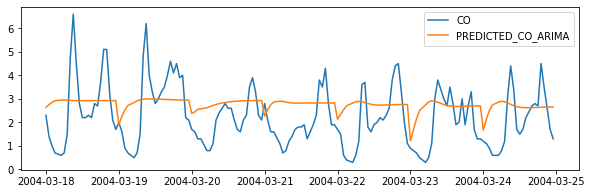

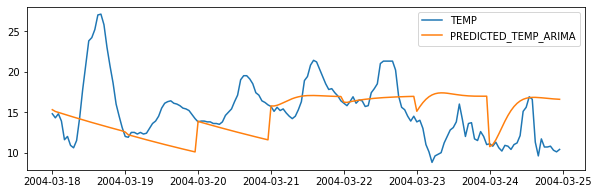

In [34]:
# Plot predictions using AutoArima
prediction_plots(predictions_co_arima, 'CO', 'PREDICTED_CO_ARIMA')
prediction_plots(predictions_temp_arima, 'TEMP', 'PREDICTED_TEMP_ARIMA')

*Facebook Prophet*

In [35]:
def fbprophet(cols, param):
  # Create dataframe to store predictions
  predictions = pd.DataFrame()

  # Create empty list to store mape values
  mape_list = []
  # Iterate for all test dates
  for d in test_dates:
    mape_values = []

    # Get train set and test set
    test = df[(df['DATE_TIME'].dt.date == d)].reset_index(drop = True)
    train_df = df[(df['DATE_TIME'].dt.date >= train_start_date) & (df['DATE_TIME'].dt.date < d)].sort_values(by = ['DATE_TIME']).dropna(subset = [param])

    output_df = test[['DATE_TIME', param]].reset_index(drop = True).dropna(subset = [param])

    # Iterate through the feature engineered columns and make predictions using each of them
    for col in cols:
      # Filter columns  for training FBProphet
      train = train_df[['DATE_TIME', col, 'DAY_sin', 'DAY_cos', 'HOUR_sin', 'HOUR_cos']]
      # Rename columns as required by model
      train.rename(columns = {'DATE_TIME' : 'ds', col : 'y'}, inplace = True)

      # Train prophet model and make predictions
      model = Prophet(weekly_seasonality = True)
      # Add holidays
      model.add_country_holidays(country_name = 'Italy')
      # Add cyclical data as regressors 
      model.add_regressor('DAY_sin')
      model.add_regressor('DAY_cos')
      model.add_regressor('HOUR_sin')
      model.add_regressor('HOUR_cos')
      model.fit(train)

      # Create future daatframe
      future = model.make_future_dataframe(periods = len(test), freq = 'H', include_history = False)
      # Add regressors as columns to future dataframes
      future['DAY_sin'] = test['DAY_sin']
      future['DAY_cos'] = test['DAY_cos']
      future['HOUR_sin'] = test['HOUR_sin']
      future['HOUR_cos'] = test['HOUR_cos']

      # Predict and calculate MAPE
      forecast = model.predict(future)
      mape_values.append(mean_absolute_percentage_error(test[col], forecast.yhat))

      # Generate output df
      output_df['PREDICTED_' + col + '_FBPROPHET'] = forecast.yhat
      predictions = predictions.append(output_df)

		# Drop NaN's resulting from append operation
    predictions = predictions.dropna()

		# Append MAPE values
    mape_list.append(mape_values)

  # Create df from mape_list
  mape_df = pd.DataFrame(mape_list, columns = cols, index = test_dates)
  mape_df.loc['Average'] = mape_df.mean()
    
  return mape_df, predictions

In [36]:
def fbprophet_predictions_all():
  cols_co = ['LIN_INTERPOLATE_CO', 'BFILL_CO', 'FFILL_CO', 'SMA_CO_1_DAY', 'SMA_CO_7_DAY', 'AVG_CO']
  cols_temp = ['TEMP']

  # Get CO and TEMP predicitons using fbprophet
  mape_co, predictions_co = fbprophet(cols_co, 'CO')
  mape_temp, predictions_temp = fbprophet(cols_temp, 'TEMP')

  # Write to excel
  with pd.ExcelWriter('Predictions_FbProphet.xlsx') as writer:  
    predictions_co.to_excel(writer, sheet_name = 'CO_FbProphet')
    predictions_temp.to_excel(writer, sheet_name = 'Temp_FbProphet')

  return mape_co, mape_temp, predictions_co, predictions_temp

In [37]:
mape_co_fbprophet, mape_temp_fbprophet, predictions_co_fbprophet, predictions_temp_fbprophet = fbprophet_predictions_all()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

In [38]:
# MAPE values for CO and TEMP using Facebook Prophet
mape_fbprophet = pd.concat([mape_co_fbprophet, mape_temp_fbprophet], axis = 1)
mape_fbprophet

,LIN_INTERPOLATE_CO,BFILL_CO,FFILL_CO,SMA_CO_1_DAY,SMA_CO_7_DAY,AVG_CO,TEMP
2004-03-18,0.659339,0.666841,0.652909,0.633768,0.632948,0.652909,0.099684
2004-03-19,0.522528,0.528673,0.518139,0.498610,0.498033,0.518139,0.393012
2004-03-20,0.370997,0.370749,0.371151,0.371513,0.371505,0.371151,0.211996
2004-03-21,0.701494,0.710872,0.695046,0.685088,0.679878,0.695046,0.169529
2004-03-22,0.368296,0.364550,0.371105,0.386494,0.387852,0.371105,0.205373
2004-03-23,0.585384,0.601654,0.575622,0.545994,0.544219,0.575622,0.473194
2004-03-24,0.410126,0.412725,0.406935,0.382435,0.387670,0.406935,0.250745
Average,0.516881,0.522295,0.512987,0.500557,0.500301,0.512987,0.257648


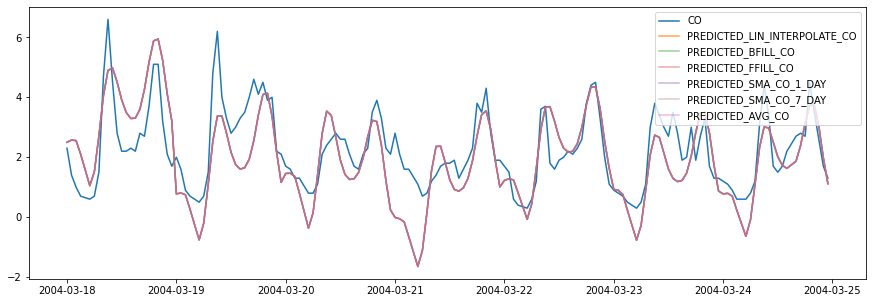

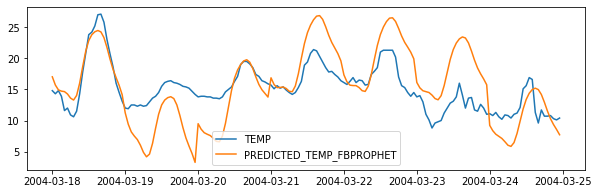

In [39]:
# Plot predictions using FB Prophet
plt.subplots(figsize = (15, 5))
plt.plot(predictions_co_fbprophet.DATE_TIME, predictions_co_fbprophet.CO)
plt.plot(predictions_co_fbprophet.DATE_TIME, predictions_co_fbprophet.PREDICTED_LIN_INTERPOLATE_CO_FBPROPHET, alpha = 0.7)
plt.plot(predictions_co_fbprophet.DATE_TIME, predictions_co_fbprophet.PREDICTED_BFILL_CO_FBPROPHET, alpha = 0.5)
plt.plot(predictions_co_fbprophet.DATE_TIME, predictions_co_fbprophet.PREDICTED_FFILL_CO_FBPROPHET, alpha = 0.4)
plt.plot(predictions_co_fbprophet.DATE_TIME, predictions_co_fbprophet.PREDICTED_SMA_CO_1_DAY_FBPROPHET, alpha = 0.5)
plt.plot(predictions_co_fbprophet.DATE_TIME, predictions_co_fbprophet.PREDICTED_SMA_CO_7_DAY_FBPROPHET, alpha = 0.3)
plt.plot(predictions_co_fbprophet.DATE_TIME, predictions_co_fbprophet.PREDICTED_AVG_CO_FBPROPHET, alpha = 0.5)
plt.legend(['CO', 'PREDICTED_LIN_INTERPOLATE_CO', 'PREDICTED_BFILL_CO', 'PREDICTED_FFILL_CO', 'PREDICTED_SMA_CO_1_DAY', 'PREDICTED_SMA_CO_7_DAY', 'PREDICTED_AVG_CO'])
plt.show()

prediction_plots(predictions_temp_fbprophet, 'TEMP', 'PREDICTED_TEMP_FBPROPHET')

*Neural Prophet*

In [40]:
def choose_hyperparameters(train_end_date, val_start_date, val_end_date, col):
	# Create train set
	train_df = df[(df['DATE_TIME'].dt.date >= train_start_date) & (df['DATE_TIME'].dt.date <= train_end_date)].sort_values(by = ['DATE_TIME']).dropna(subset = [col])
	train_data = train_df[['DATE_TIME', col]]
	train_data.columns = ['ds', 'y']

	# Create validation set to choose hyperparameters
	val_df = df[(df['DATE_TIME'].dt.date >= val_start_date) & (df['DATE_TIME'].dt.date <= val_end_date)].sort_values(by = ['DATE_TIME']).dropna(subset = [col])
	val_data = val_df[['DATE_TIME', col]]
	val_data.columns = ['ds', 'y']

	# Dataframe to save the hyperparameters
	model_parameters = pd.DataFrame(columns = ['MAPE', 'PARAMETERS'])

	# ParameterGrid
	params_grid = {'num_hidden_layers' : (1, 2, 4, 8),
					'learning_rate' : [0.0001, 0.001, 0.01, 0.05, 0.1, 1]}
	grid = ParameterGrid(params_grid)

	# For each combination of parameters
	for p in grid:
		random.seed(0)
		# Train neural prophet net and predict on validation set
		train_model = NeuralProphet(growth = 'off', 
                                  daily_seasonality = True, 
                                  loss_func = 'MAE',
                                  num_hidden_layers = p['num_hidden_layers'],
                                  learning_rate = p['learning_rate'],
                                  normalize = 'off',
                                  seasonality_mode = 'additive')
		train_model.fit(train_data, freq ='H')
		p['epochs'] = train_model.config_train.epochs
		p['batch_size'] = train_model.config_train.batch_size

		forecast = train_model.predict(val_data)

		# Store mape values of validation set
		MAPE =  mean_absolute_percentage_error(forecast.y, forecast.yhat1)
		model_parameters = model_parameters.append({'MAPE' : MAPE, 'PARAMETERS' : p}, ignore_index = True)

	return model_parameters

def predict_neural_prophet(model_parameters, col):
	# Create empty lists to store MAPE values and forecasts
	mape_list = []
	forecasts = []
	# Create empty dataframe to store predictions
	predictions = pd.DataFrame()

	for i, d in enumerate(test_dates):
		# Get train set
		train_df = df[(df['DATE_TIME'].dt.date >= train_start_date) & (df['DATE_TIME'].dt.date < d)].sort_values(by = ['DATE_TIME']).dropna(subset = [col])
		train = train_df[['DATE_TIME', col]]
		train.columns = ['ds', 'y']

		# Get test set
		test_df = df[(df['DATE_TIME'].dt.date == d)].dropna(subset = [col]).reset_index(drop = True)
		test = test_df[['DATE_TIME', col]]
		test.columns = ['ds', 'y']

		random.seed(0)

		# Extract trianed hyperparameters
		hyperparameters = model_parameters.loc[model_parameters.DATE == d, 'PARAMETERS']
		num_hidden_layers = hyperparameters[i]['num_hidden_layers']
		learning_rate = hyperparameters[i]['learning_rate']
		epochs = hyperparameters[i]['epochs']
		batch_size = hyperparameters[i]['batch_size']

		# Train neural prophet and forecast
		model = NeuralProphet(growth = 'off', 
							daily_seasonality = True,
							loss_func = 'MAE',
							num_hidden_layers = num_hidden_layers,
							learning_rate = learning_rate,
							normalize = 'off',
							seasonality_mode = 'additive',
							epochs = epochs,
							batch_size = batch_size)
		model.fit(train, freq ='H')
		forecast = model.predict(test)
		forecast = forecast.reset_index(drop = True)
		test['PREDICTED_' + col + '_NEURALPROPHET'] = forecast.yhat1

		# Create output df
		test_filtered = test[['ds', 'y', 'PREDICTED_' + col + '_NEURALPROPHET']]
		test_filtered.columns = ['DATE_TIME', col, 'PREDICTED_' + col + '_NEURALPROPHET']
		predictions = predictions.append(test_filtered)

		# Calculate MAPE
		mape =  mean_absolute_percentage_error(test_filtered[col], test_filtered['PREDICTED_' + col + '_NEURALPROPHET'])
		mape_list.append(mape)

	predictions = predictions.reset_index()

	return mape_list, predictions

def neural_prophet(col):
	# Set varaibles
	no_of_days = 7
	train_start = 11
	train_counter = 4
	val_start = 16
	val_counter = 0
	test_start = 18
	test_counter = 0

	# Dataframe to store optimal parameters for each day in test set
	model_parameters = pd.DataFrame(columns = ['DATE', 'PARAMETERS'])

	for day in range(0, no_of_days):
		# Run for all combinations of hyper parameters
		model_tuning = choose_hyperparameters(date(2004, 3, train_start + train_counter), date(2004, 3, val_start + val_counter), date(2004, 3, val_start + val_counter + 1), col)  

		train_counter += 1
		val_counter += 1

		# Store hyperparameters which gives minimum MAPE on validaiton set
		parameters = model_tuning.sort_values(by = ['MAPE']).reset_index(drop = True)
		model_parameters = model_parameters.append({'DATE' : date(2004, 3, test_start + test_counter), 'PARAMETERS' : parameters['PARAMETERS'][0]}, ignore_index = True)
		test_counter += 1

	mape_list, predictions = predict_neural_prophet(model_parameters, col)

	# Convert mape_list to df and calculate avergae mape for test set
	mape_df = pd.DataFrame(mape_list, columns = [col], index = test_dates)
	mape_df.loc['Average'] = mape_df.mean()

	# Return mape dataframe and predictions dataframe
	return mape_df, predictions

In [41]:
def neural_prophet_predictions_all():
	# Get CO and TEMP predicitons using auto_arima
	mape_co, predictions_co = neural_prophet('CO')
	mape_temp, predictions_temp = neural_prophet('TEMP')

	# Write to excel
	with pd.ExcelWriter('Predictions_NeuralProphet.xlsx') as writer:
		predictions_co.to_excel(writer, sheet_name = 'CO_NeuralProphet')
		predictions_temp.to_excel(writer, sheet_name = 'Temp_NeuralProphet')

	return mape_co, mape_temp, predictions_co, predictions_temp

In [42]:
mape_co_neuralprophet, mape_temp_neuralprophet, predictions_co_neuralprophet, predictions_temp_neuralprophet = neural_prophet_predictions_all()

INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO:NP.config:Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 308
INFO:NP.config:Auto-set epochs to 308
Epoch[308/308]: 100%|██████████| 308/308 [00:05<00:00, 52.24it/s, L1Loss=2.85, MAE=2.85, RMSE=3.18, RegLoss=0]
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. R

In [43]:
# MAPE values for CO and TEMP using Neural Prophet
mape_neuralprophet = pd.concat([mape_co_neuralprophet, mape_temp_neuralprophet], axis = 1)
mape_neuralprophet

,CO,TEMP
2004-03-18,0.253505,0.051531
2004-03-19,0.343960,0.241133
2004-03-20,0.186616,0.086763
2004-03-21,0.463026,0.087637
2004-03-22,0.352109,0.127125
2004-03-23,0.578151,0.346471
2004-03-24,0.256816,0.403168
Average,0.347740,0.191975


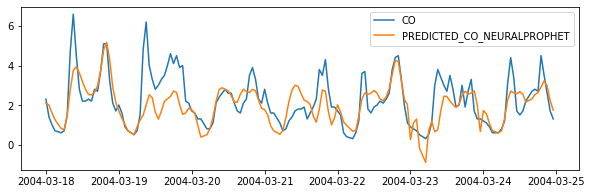

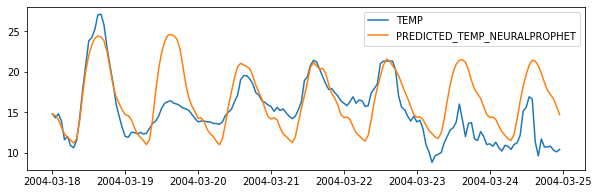

In [44]:
# Plot predictions using Neural Prophet
prediction_plots(predictions_co_neuralprophet, 'CO', 'PREDICTED_CO_NEURALPROPHET')
prediction_plots(predictions_temp_neuralprophet, 'TEMP', 'PREDICTED_TEMP_NEURALPROPHET')

In [45]:
mape_co_exponentialsmoothing.columns = ['CO_ExponentialSmoothing']
mape_co_arima.columns = ['CO_AutoArima']
mape_co_fbprophet = mape_co_fbprophet[['SMA_CO_7_DAY']]
mape_co_fbprophet.columns = ['CO_FacebookProphet']
mape_co_neuralprophet.columns = ['CO_NeuralProphet']

# Combine all mape values for CO
co_concat_mape = pd.concat([mape_co_exponentialsmoothing, mape_co_arima, mape_co_fbprophet, mape_co_neuralprophet], axis = 1)
co_concat_mape

,CO_ExponentialSmoothing,CO_AutoArima,CO_FacebookProphet,CO_NeuralProphet
2004-03-18,0.479754,0.835220,0.632948,0.253505
2004-03-19,0.529232,0.783793,0.498033,0.343960
2004-03-20,0.273057,0.587450,0.371505,0.186616
2004-03-21,0.230828,0.797220,0.679878,0.463026
2004-03-22,0.734041,1.297360,0.387852,0.352109
2004-03-23,0.696812,1.178952,0.544219,0.578151
2004-03-24,0.566951,0.891762,0.387670,0.256816
Average,0.501525,0.910251,0.500301,0.347740


In [46]:
mape_temp_exponentialsmoothing.columns = ['Temp_ExponentialSmoothing']
mape_temp_arima.columns = ['Temp_AutoArima']
mape_temp_fbprophet.columns = ['Temp_FacebookProphet']
mape_temp_neuralprophet.columns = ['Temp_NeuralProphet']

# Combine all mape values for Temp
temp_concat_mape = pd.concat([mape_temp_exponentialsmoothing, mape_temp_arima, mape_temp_fbprophet, mape_temp_neuralprophet], axis = 1)
temp_concat_mape

,Temp_ExponentialSmoothing,Temp_AutoArima,Temp_FacebookProphet,Temp_NeuralProphet
2004-03-18,0.082678,0.265608,0.099684,0.051531
2004-03-19,0.139071,0.203722,0.393012,0.241133
2004-03-20,0.117455,0.183328,0.211996,0.086763
2004-03-21,0.098078,0.091781,0.169529,0.087637
2004-03-22,0.153658,0.098580,0.205373,0.127125
2004-03-23,0.310662,0.425929,0.473194,0.346471
2004-03-24,0.175360,0.342143,0.250745,0.403168
Average,0.153852,0.230156,0.257648,0.191975
